# Lecture : Recommendation on Graphs

## Lab 05 : Preparing the real-world dataset SWEETRS

### Xavier Bresson   


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/05_Recommendation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from IPython.display import display, clear_output
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import shrink
import scipy.sparse.linalg
import warnings; warnings.filterwarnings("ignore")
import torch
from lib.utils import compute_ncut, reindex_W_with_classes, construct_knn_graph
from scipy.io import savemat
from pandas import read_csv
import networkx as nx


In [3]:
# Real-world dataset SWEETRS (Sweet Recommender System)
# https://paperswithcode.com/dataset/sweetrs
# https://github.com/kidzik/sweetrs-analysis
# https://raw.githubusercontent.com/kidzik/sweetrs-analysis/master/ratings-final.csv
# 1,476 users submitted 33,692 grades for 77 candies, 39.2% of available ratings

# ratings-final.csv => ratings-sweetrs.csv  
  # "product","user","value"
  # "Raffaello",1476,5
  # "Toblerone white",1476,2
  # "Haribo",1476,2
  # etc

data = read_csv('datasets/ratings-sweetrs.csv')
# converting data columns to lists
product = data['product'].tolist()
user = data['user'].tolist()
value = data['value'].tolist()
num_ratings = len(product)

# Print first 100
print('product[:100]:',product[:100])
print('user[:100]:',user[:100])
print('value[:100]:',value[:100])
print('num_ratings:',num_ratings)


product[:100]: ['Raffaello', 'Toblerone white', 'Haribo', 'Mars', 'Snickers', 'Mars', 'Raffaello', 'Toblerone white', 'Haribo', 'Snickers', 'Magnum Almond', 'Mentos Mint', 'Magnum Almond', 'Mentos Mint', 'Haribo', 'Mars', 'Snickers', 'Toblerone white', 'Raffaello', 'Mentos Mint', 'Snickers', 'Raffaello', 'Toblerone white', 'Magnum Almond', 'Haribo', 'Mars', 'Mentos Mint', 'Snickers', 'Toblerone white', 'Raffaello', 'Mars', 'Magnum Almond', 'Haribo', "Fisherman's Friend", "Fisherman's Friend", 'Lentilky', 'Skittles', 'Twix', 'Maltesers', 'Lentilky', 'Chupa chups', 'Lion', "Werther's Original", 'Nimm2', 'Kinder surprise', 'Kinder bueno', 'Kinder bueno white', 'KitKat', 'Milky Way', 'Kinder bueno white', 'Skittles', 'Nimm2', 'Lion', 'Maltesers', 'Lentilky', 'Kinder bueno', 'Chupa chups', "Fisherman's Friend", 'Twix', "Werther's Original", 'Prince Polo', 'Kinder surprise', 'KitKat', 'Milky Way', 'Prince Polo', 'Toffifee', 'Mamba', 'Milka Lila Stars Raisins', 'Kopiko', 'Chupa chups', 'Lenti

In [4]:
# make a dictionary of products
dictionary_product = []
num_products = 0
for item in product:
    if item not in dictionary_product:
        dictionary_product.append(item); num_products += 1
print('dictionary_product:',dictionary_product,'\n')
print('num_products (unique):',num_products,'\n') # 1476
print('max(dictionary_product):',max(dictionary_product))
product2index = { product:index for index,product in enumerate(dictionary_product) }
index2product = { index:product for index,product in enumerate(dictionary_product) }
print('product2index:', product2index,'\n')
print('index2product:', index2product,'\n')

# make a dictionary of users
dictionary_user = []
num_users = 0
for item in user:
    if item not in dictionary_user:
        dictionary_user.append(item); num_users += 1
print('dictionary_user[:10]:',dictionary_user[:10],'\n')
print('num_users (unique):',num_users,'\n') # 1476
user2index = { user:index for index,user in enumerate(dictionary_user) }
index2user = { index:user for index,user in enumerate(dictionary_user) }


dictionary_product: ['Raffaello', 'Toblerone white', 'Haribo', 'Mars', 'Snickers', 'Magnum Almond', 'Mentos Mint', "Fisherman's Friend", 'Lentilky', 'Skittles', 'Twix', 'Maltesers', 'Chupa chups', 'Lion', "Werther's Original", 'Nimm2', 'Kinder surprise', 'Kinder bueno', 'Kinder bueno white', 'KitKat', 'Milky Way', 'Prince Polo', 'Toffifee', 'Mamba', 'Milka Lila Stars Raisins', 'Kopiko', 'Ferrero rocher', 'Kaszka manna', 'Wisełka', 'Nonnette (pierniczki)', 'Mon cheri', 'Merci', "M&m's", 'Nutella', 'Bounty', 'Halls', 'Cornetto', 'Ptasie mleczko', 'Leibniz Biscuits', 'Milka White', 'Jelly (kisiel)', 'Creme puffs (ptysie)', 'Donuts ', 'Manhattan Ice Cream', 'After Eight ', 'Milka Hazelnuts', 'Knoppers', 'Duplo', 'LU Holenderskie', 'Tic tac', '7 days - cake bar', 'Alpenliebe', 'Dumle', 'Romero', 'Nogger', 'Michalki biale', 'Fruitella', 'Dzika roza', 'Chalwa', 'Grzeski dziel na 6', 'Jeżyki', 'Czekolada z okienkiem', 'Draze kokosowe korsarz', 'Pieguski', 'Schogetten', 'JoJo pianki', 'Marcepan

num_users, num_products, num_ratings: 1476 77 44543
percentage available ratings: 0.39192447119276386
1476 77
(1476, 77)


Text(0.5, 1.0, 'Original rating matrix\n Percentage observed ratings: 39.19')

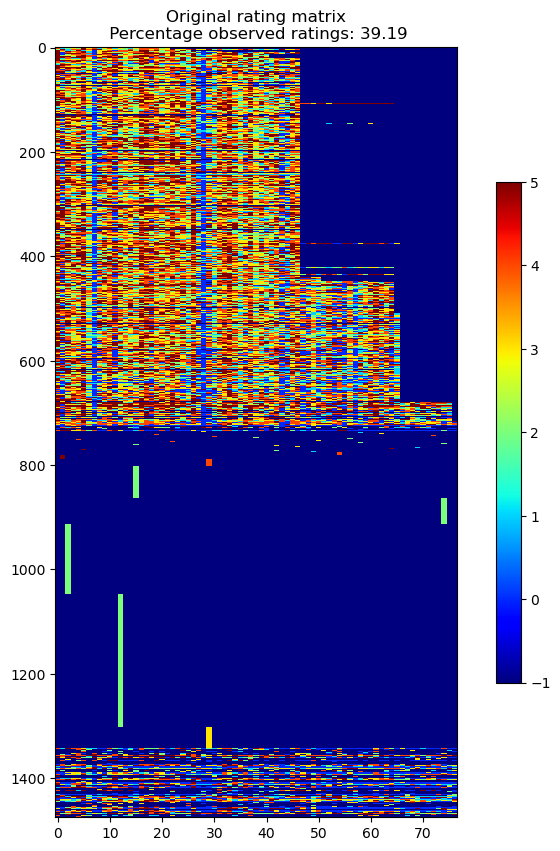

In [5]:
# Compute the original rating matrix
#  user ratings are {0,1,2,3,4,5}
#  when no rating given, the value will be -1
print('num_users, num_products, num_ratings:',num_users, num_products, num_ratings)
perc_obs_rating = num_ratings / (num_users * num_products)
print('percentage available ratings:', perc_obs_rating)
print(num_users, num_products)
Morig = -np.ones((num_users,num_products)) # initialize all ratings at -1
print(Morig.shape)
for idx in range(num_ratings):
    idx_product = product2index[product[idx]]
    idx_user = user2index[user[idx]]
    rating_value = value[idx]
    Morig[idx_user,idx_product] = rating_value

# Visualize the rating matrix
plt.figure(figsize=(10,10))
plt.imshow(Morig, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Original rating matrix\n Percentage observed ratings: ' + str(100*perc_obs_rating)[:5])


torch.Size([664, 77])
num_users_new, num_products, num_ratings_new: 664 77 47282
perc_obs_rating_new: 0.9247770301987169


Text(0.5, 1.0, 'New rating matrix\n Percentage observed ratings: 92.47')

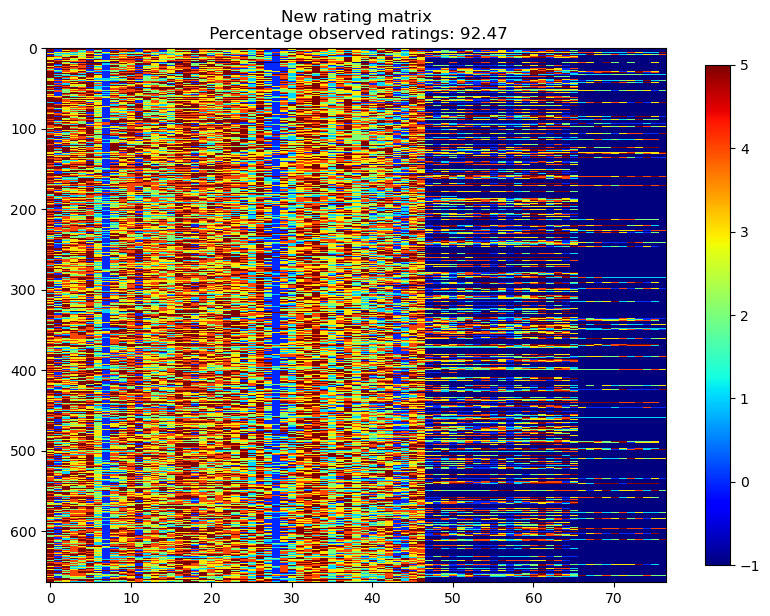

In [7]:
# Processing original rating matrix
 # Remove users with less than 50% rating
 # Randomly shuffle the order of users
Mgt = []
M = torch.tensor(Morig)
for idx_user in range(num_users):
    num_ratings_user = (M[idx_user,:]>0).sum()
    if num_ratings_user > 0.50 * num_products:
        Mgt.append(M[idx_user,:])
Mgt = torch.stack(Mgt)
num_users_new = Mgt.size(0)
idx_suffle = torch.randperm(num_users_new)
Mgt = Mgt[idx_suffle,:]
print(Mgt.size())

num_ratings_new = torch.nonzero(Mgt).size(0)
perc_obs_rating_new = num_ratings_new / (num_users_new * num_products)
print('num_users_new, num_products, num_ratings_new:',num_users_new, num_products, num_ratings_new)
print('perc_obs_rating_new:', perc_obs_rating_new)

# Visualize the new rating matrix
plt.figure(figsize=(10,10))
plt.imshow(Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('New rating matrix\n Percentage observed ratings: ' + str(100*perc_obs_rating_new)[:5])



position of ratings: torch.Size([33692, 2])
number of ratings: 33692
num_train_data: 6738
num_train_data+num_test_data: 33692
num_train_data: 6738
num_test_data: 26954
num_users, num_products: 664 77
number of train ratings: 6738
number of test ratings: 26954


Text(0.5, 1.0, 'Test mask\n Percentage training ratings: 80.00')

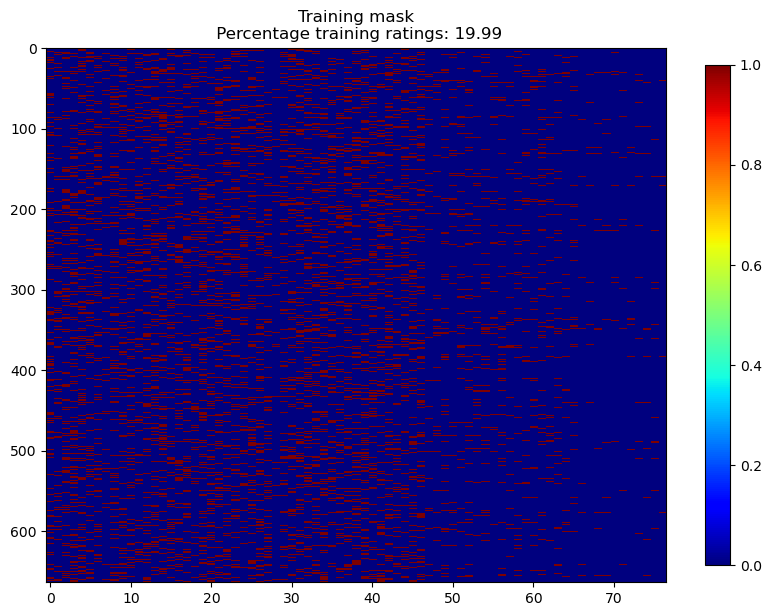

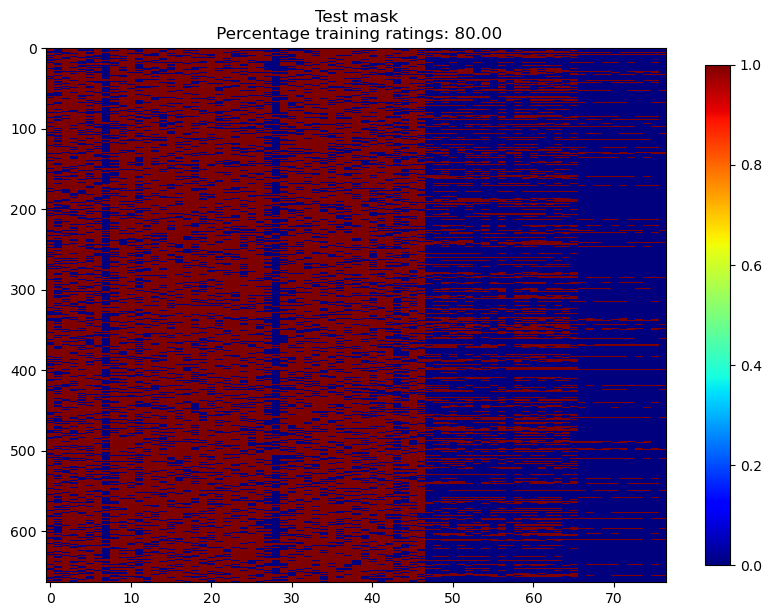

In [8]:
# Compute mask of training data
#         mask of test data

idx_nzeros = torch.nonzero(Mgt>0)
print('position of ratings:',idx_nzeros.size())
num_nzero = idx_nzeros.size(0)
print('number of ratings:',num_nzero)

# select the percentage of observed ratings in the original matrix for training and testing
perc_train = 0.02 # scenario 1 : 2% 
perc_train = 0.2  # scenario 2 : 20% 
# perc_train = 0.8  # scenario 3 : 80%

num_train_data = int(perc_train * num_nzero)
num_test_data = num_nzero - num_train_data
print('num_train_data:',num_train_data)
print('num_train_data+num_test_data:',num_train_data+num_test_data)
idx_randperm = torch.randperm(num_nzero)
idx_train_data = idx_nzeros[idx_randperm[:num_train_data]]
print('num_train_data:',len(idx_train_data))
idx_test_data = idx_nzeros[idx_randperm[num_train_data:]]
print('num_test_data:',len(idx_test_data))

num_users, num_products = Mgt.size()
print('num_users, num_products:',num_users, num_products)
Otraining = torch.zeros(num_users, num_products)
for idx in idx_train_data:
    Otraining[idx[0],idx[1]] = 1
print('number of train ratings:',torch.nonzero(Otraining).size(0))
Otest = torch.zeros(num_users, num_products)
for idx in idx_test_data:
    Otest[idx[0],idx[1]] = 1
print('number of test ratings:',torch.nonzero(Otest).size(0))

# Visualize the training mask
plt.figure(figsize=(10,10))
plt.imshow(Otraining, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Training mask\n Percentage training ratings: ' + str(100*torch.nonzero(Otraining).size(0)/num_nzero)[:5])

# Visualize the test mask
plt.figure(figsize=(10,10))
plt.imshow(Otest, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Test mask\n Percentage training ratings: ' + str(100*torch.nonzero(Otest).size(0)/num_nzero)[:5])


In [ ]:
# Compute graph of users    / rows    
#         graph of products / columns 

# Graph of users 
X = Mgt.numpy()

# # Construct medium-quality graph with 50% of original ratings -- comment this part or not
# # only select 50% of rating
# idx_nzeros = torch.nonzero(Mgt>0)
# num_nzero = idx_nzeros.size(0)
# perc_rating = 0.5 
# num_graph_data = int(perc_rating * num_nzero)
# print('num_data, num_graph_data:', num_nzero, num_graph_data)
# idx_randperm = torch.randperm(num_nzero)
# idx_graph_data = idx_nzeros[idx_randperm[:num_graph_data]]
# num_users, num_products = Mgt.size()
# print('num_users, num_products:',num_users, num_products)
# X = torch.zeros(num_users, num_products)
# for idx in idx_graph_data:
#     X[idx[0],idx[1]] = 1
# print('num_graph_data:',len(idx_graph_data))
# X = X.numpy()
# # Compute k-NN graph with cosine distance
# W = Wrow = construct_knn_graph(X, 10, 'cosine_binary') # best
# # END Construct medium-quality graph with 50% of original ratings 

# # Construct high-quality graph with 100% of original ratings -- comment this part or not
# Compute k-NN graph with cosine distance
W = Wrow = construct_knn_graph(X, 10, 'cosine') 
# # END Construct high-quality graph with 100% of original ratings

# Evaluate the graph construction by visualizing the adjacency matrix
nc = 10
Cncut, _ = compute_ncut(W, torch.zeros(Mgt.size(0)).numpy(), nc) # compute NCut clustering 
[reindexed_W_ncut,reindexed_C_ncut] = reindex_W_with_classes(W,Cncut)
# plot adjacency matrix w.r.t. NCut communities
plt.figure(1)
plt.spy(reindexed_W_ncut, precision=0.01, markersize=1)
plt.title('Adjacency Matrix A indexed according to the NCut communities')
plt.show()
# plot graph of users
A = W.copy()
A.setdiag(0) 
A.eliminate_zeros()
G_nx = nx.from_scipy_sparse_array(A)
plt.figure(2,figsize=[30,30])
nx.draw_networkx(G_nx, with_labels=True, node_color=np.array(Cncut), cmap='jet')

# Graph of products 
X = Mgt.transpose(1,0).numpy()
# Compute k-NN graph with euclidean distance
W = Wcol = construct_knn_graph(X, 15, 'cosine_binary')

# Evaluate the graph construction by visualizing the adjacency matrix
nc = 10
Cncut, _ = compute_ncut(W, torch.zeros(Mgt.size(1)).numpy(), nc)
[reindexed_W_ncut,reindexed_C_ncut] = reindex_W_with_classes(W,Cncut) # compute NCut clustering 
# plot adjacency matrix w.r.t. NCut communities
plt.figure(3)
plt.spy(reindexed_W_ncut, precision=0.01, markersize=1)
plt.title('Adjacency Matrix A indexed according to the NCut communities')
plt.show()
# plot graph of products
A = W.copy()
A.setdiag(0) 
A.eliminate_zeros()
G_nx = nx.from_scipy_sparse_array(A)
plt.figure(4,figsize=[30,30])
nx.draw_networkx(G_nx, with_labels=True, node_color=np.array(Cncut), cmap='jet')



k-NN graph with cosine distance


In [ ]:
# save data
M = Mgt.numpy()
Otraining = Otraining.numpy()
Otest = Otest.numpy()
savemat('datasets/real_sweetrs.mat',{'M': M, 'Otraining': Otraining, 'Otest': Otest, 'Wrow': Wrow, 'Wcol': Wcol})

# checking : load data
mat = scipy.io.loadmat('datasets/real_sweetrs.mat')
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']
print('M', M.shape)
print('Otraining', Otraining.shape)
print('Otest', Otest.shape)
print('Wrow', Wrow.shape)
print('Wcol', Wcol.shape)
